# Problem description

To a large degree, financial data has traditionally been numeric in format.

But in recent years, non-numeric formats like image, text and audio have been introduced.  

Private companies have satellites orbiting the Earth taking photos and offering them to customers.  A financial analyst might be able to extract information from these photos that could aid in the prediction of the future price of a stock

- Approximate number of customers visiting each store: count number of cars in parking lot
- Approximate activity in a factory by counting number of supplier trucks arriving and number of delivery trucks leaving
- Approximate demand for a commodity at each location: count cargo ships travelling between ports

In this assignment, we will attempt to recognize ships in satellite photos.
This would be a first step toward
counting.

As in any other domain: specific knowledge of the problem area will make you a better analyst.
For this assignment, we will ignore domain-specific information and just try to use a labelled training set (photo plus a binary indicator for whether a ship is present/absent in the photo), assuming that the labels are perfect.

## Goal: 

In this notebook, you will need to create a model in `TensorFlow/Keras` to classify satellite photos.
- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - This notebook will retrieve the saved model and test your results.

You will create several Keras `Sequential` models, of increasing complexity
- A model that implements only a Classification Head (no transformations other than perhaps rearranging the image)
- A model that adds a Dense layer before the head
- (Later assignment) A model that adds Convolutional layers before the Head

## Learning objectives
- Learn how to construct Neural Networks using Keras Sequential model
- Appreciate how layer choices impact number of weights

# Imports modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.2.0
Version 2, minor 2


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labelled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [2]:
## Load the helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import helper module
import helper
%aimport helper

helper = helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [3]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape
print("Date shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))


Date shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [4]:
# Shuffle the data first
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

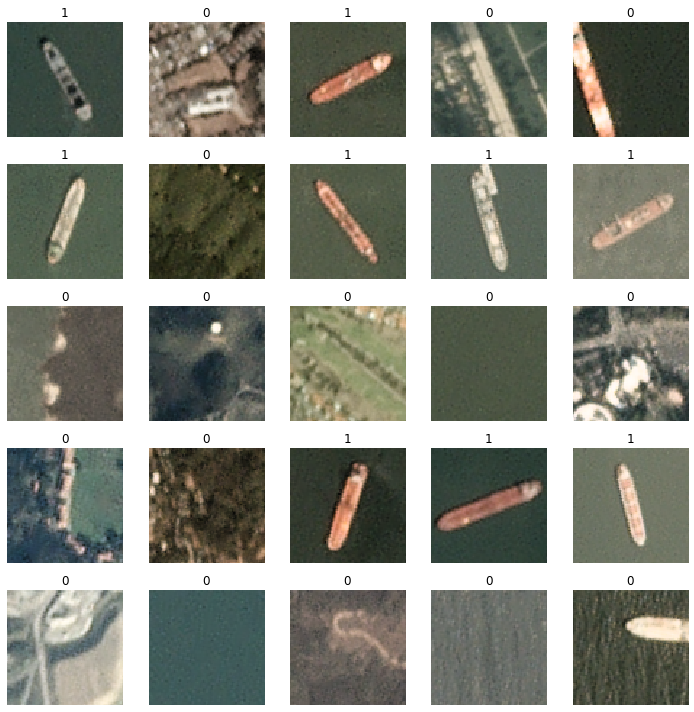

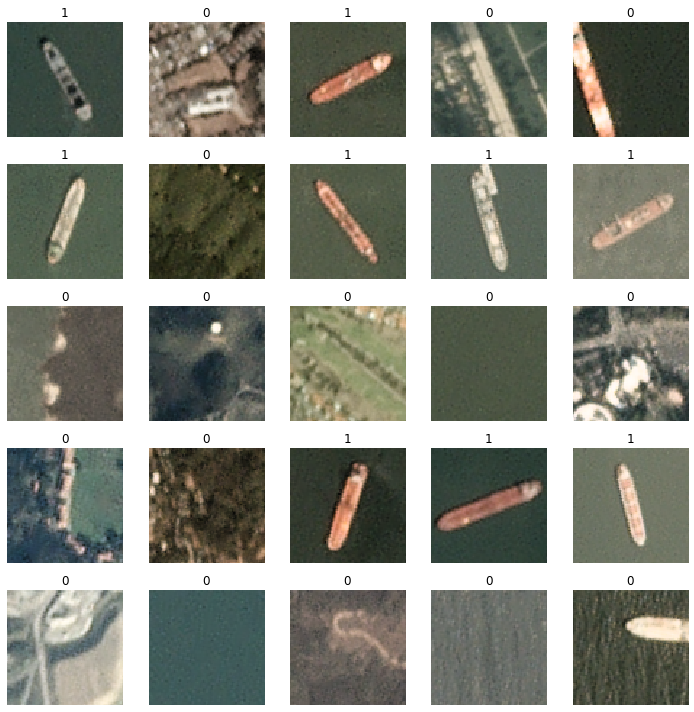

In [5]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.

In [ ]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ])
    fig.suptitle("Label: "+  str(lab), fontsize=14)
    fig.show()
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255. In addition, we usually use one-hot encoding to deal with our labels. 

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our examples (`data`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values

In [6]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

### BEGIN SOLUTION
X = data / 255.
y = labels
### END SOLUTION

In [7]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert y.shape == (4000, )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [8]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a model using only Classification, no data transformation (other than reshaping)

**Question:** You need to build a 1-layer (head layer only) network model with `tensorflow.keras`. Please name the head layer "dense_head". 

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. Since the dataset is 3-dimensional, you may want to use `Flatten()` in `tensorflow.keras.layers` to make your input data 1 dimensional. 
    - The `input shape` argument of the `Flatten()` layer should be the shape of a single example
2. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`
3. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimensio equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

In [9]:
# Get the number of unique labels
num_cases = np.unique(y).shape[0]

if y.ndim == 2 and num_cases >=2:
    activation = "softmax"
else:
    activation = "sigmoid"
    num_cases = 1
    
# Set model0 equal to a Keras Sequential model
model0 = None

### BEGIN SOLUTION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model0 = Sequential()
model0.add(Flatten(input_shape=(X.shape[1:])))
model0.add(Dense(num_cases, activation=activation, name='dense_head'))
### END SOLUTION

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 19201     
Total params: 19,201
Trainable params: 19,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We can plot our model here using plot_model()
plot_model(model0)

## Train model

**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Set the model name to be "Head Only" and store it in a variable `model_name0`
- Use exactly 15  epochs for training
- Save your training results in a variable named `history0`
- Plot your training results using the `plotTrain` method described in the Student API above.

Epoch 1/15
90/90 [==============================] - 0s 3ms/step - loss: 1.2937 - accuracy: 0.7056 - val_loss: 0.3697 - val_accuracy: 0.8472
Epoch 2/15
90/90 [==============================] - 0s 3ms/step - loss: 0.9039 - accuracy: 0.7625 - val_loss: 0.3598 - val_accuracy: 0.8500
Epoch 3/15
90/90 [==============================] - 0s 3ms/step - loss: 0.7662 - accuracy: 0.8007 - val_loss: 0.4856 - val_accuracy: 0.8472
Epoch 4/15
90/90 [==============================] - 0s 3ms/step - loss: 0.7564 - accuracy: 0.8122 - val_loss: 0.3490 - val_accuracy: 0.8694
Epoch 5/15
90/90 [==============================] - 0s 3ms/step - loss: 0.7396 - accuracy: 0.8083 - val_loss: 0.4766 - val_accuracy: 0.8347
Epoch 6/15
90/90 [==============================] - 0s 3ms/step - loss: 0.7436 - accuracy: 0.8153 - val_loss: 0.8479 - val_accuracy: 0.7014
Epoch 7/15
90/90 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.8267 - val_loss: 0.4319 - val_accuracy: 0.8681
Epoch 8/15
90/90 [==

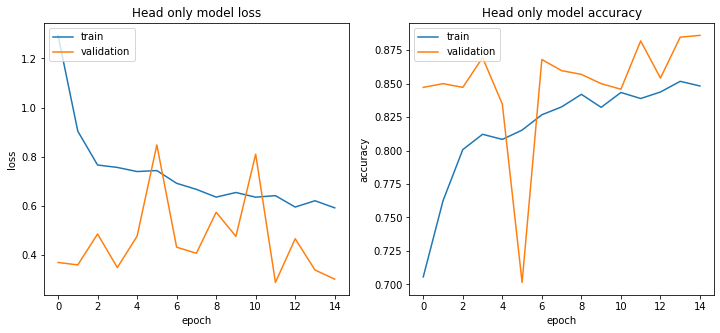

In [14]:
# Set the model name
model_name0 = "Head only"

### BEGIN SOLUTION
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model0.compile(loss='binary_crossentropy', metrics=['accuracy'])
history0 = model0.fit(X_train_, y_train_, epochs=15, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history0, model_name0)
### END SOLUTION

## How many weights in the model ?

**Question:**   

Calculate the number of parameters in your model.  
- Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.


In [15]:
# Set num_parameters0 equal to the number of weights in the model
num_parameters0 = None

### BEGIN SOLUTION
num_parameters0 = model0.count_params()
### END SOLUTION

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  19201


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [16]:
score0 = []

### BEGIN SOLUTION
score0 = model0.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

Head only: Test loss: 0.32 / Test accuracy: 0.89


## Save the trained model0 and history0 for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [17]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory ./models/Head only already exists, files will be over-written.
INFO:tensorflow:Assets written to: ./models/Head only/assets
Model saved in directory ./models/Head only; create an archive of this directory and submit with your assignment.
Directory ./models/Head only already exists, files will be over-written.


In [18]:
## Restore the model (make sure that it works)

model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a new model with an additional Dense layer 

**Question:** 

We will add more layers to the original model0. 

- You need to add **AT LEAST ONE** Dense layer followed by an activation function (for example, ReLU)
    - You can add more layers if you like
    
- The number of units in your very **FIRST** Dense layer should be equal to the value of variable `num_features_1`, as set below.
    - Please name this Dense layer "dense_1" and the head layer "dense_head". 

**Hints:**
- Don't forget to flatten your input data!
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 

Hopefully your new model performs **better** than your first.

In [22]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_features_1 = 32

### BEGIN SOLUTION
from tensorflow.keras.layers import Dropout

model1 = Sequential()
model1.add(Flatten(input_shape=(X.shape[1:])))
model1.add(Dropout(0.2))
model1.add(Dense(num_features_1, activation='relu', name='dense_1'))
model1.add(Dense(num_cases, activation=activation, name='dense_head'))
### END SOLUTION

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 19200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                614432    
_________________________________________________________________
dense_head (Dense)           (None, 1)                 33        
Total params: 614,465
Trainable params: 614,465
Non-trainable params: 0
_________________________________________________________________


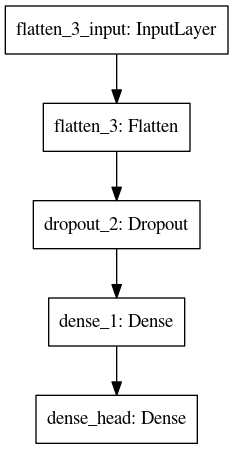

In [23]:
# Plot your model
plot_model(model1)

## Train your new model

**Question:**

Now that you have built your new model1,  you will compile and train model1. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Set the model name to be "Dense + Head" and store it in a variable `model_name0`
- Use exactly 15  epochs for training
- Save your training results in a variable named `history1`
- Plot your training results using the`plotTrain` method described in the Student API above.


In [ ]:
# Train the model using the API
model_name1 = "Dense + Head"

### BEGIN SOLUTION
# X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model1.compile(loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train_, y_train_, epochs=15, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history1, model_name1)
### END SOLUTION

The loss and accuracy graphs of model1 are similiar to this:
<img src="./images/model1_loss_accuracy.png" style="width:600px;height:300px;">

We can see that the loss curves decrease with epoch number, which means our model is learning!

## How many weights in this model ?

**Question:** 

Calculate the number of parameters in your new model.  
- Set variable `num_parameters1` to be equal to the number of parameters in your model.

In [ ]:
# Set num_parameters1 equal to the number of weights in the model
num_parameters1 = None

### BEGIN SOLUTION
num_parameters1 = model1.count_params()
### END SOLUTION

print('Parameters number in model1:', num_parameters1)

## Evaluate the model

**Question:** 

Evaluate the new model using the test dataset. Please store the model score in a variable named `score1`.   

In [ ]:
score1 = []

### BEGIN SOLUTION
score1 = model1.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

# Save your trained model1 and history1

In [13]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory ./models/Dense + Head already exists, files will be over-written.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/Dense + Head/assets
Model saved in directory ./models/Dense + Head; create an archive of this directory and submit with your assignment.
Directory ./models/Dense + Head already exists, files will be over-written.


## Your own model (Optional)
Now you can build your own model using what you have learned from the course. Some ideas to try:
- Try more than one additional `Dense` layer 
- Change the number of units (features) of your `Dense` layers. 
- Add `Dropout` layers; vary the parameter 
- Change the activation function
- Change the classifier
- ...

Observe the effect of each change on the Loss and Accuracy.
- You may want to use early stopping in training
    - In order to stop training when model metrics *worsen* rather than *improve*

## Now Submit your assignment!
Please click on the blue button <span style="color: blue;"> **Submit** </span> in this notebook. 